In [27]:
import sys, os, pathlib
sys.path.append("/root/shared/gitrepos/smart-comp-sci/utils")
sys.path.append("/root/shared/gitrepos/smart-comp-sci/mechanotransduction-example")
import smart_analysis
from mechanotransduction_ode import mechanotransduction_ode_calc
from matplotlib import pyplot as plt
import matplotlib
params = {'axes.labelsize': 12,
            'axes.titlesize': 6,
            'legend.fontsize': 10,
            'xtick.labelsize':10,
            'ytick.labelsize': 10,
            'figure.figsize': (5.5,4),
            'pdf.fonttype': 42,
            'ps.fonttype': 42,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'legend.loc': "best"}
matplotlib.rcParams.update(params)
import numpy as np
cur_dir = "/root/shared/gitrepos/smart-comp-sci/mechanotransduction-example"

In [ ]:
mesh_dir = "/root/shared/gitrepos/smart-comp-sci-data/meshes/nanopillars"
if True:#"results-redo" not in os.listdir(cur_dir):
    files_dir = "/root/scratch/smart-comp-sci-data/mechanotransduction/results_nanopillars"
    npy_dir = pathlib.Path("/root/shared/gitrepos/smart-comp-sci/mechanotransduction-example/npy-files-nanopillars")
    npy_dir.mkdir(exist_ok=True)
    test_folders = os.listdir(files_dir)
    condition_str = []
    for i in range(len(test_folders)):
        # subfolders = os.listdir(f"{files_dir}/{test_folders[i]}")
        # if len(subfolders) != 2: # should be 2 folders, one with mesh and one with results
        #     condition_str.append("")
        #     continue
        mesh_file = ""
        # for file in os.listdir(f"{files_dir}/{test_folders[i]}"):
        #     if file.endswith(".h5") and "mesh" in file:
        #         mesh_file = f"{files_dir}/{test_folders[i]}/{file}"
        #         break
        for folder in os.listdir(mesh_dir):
            if folder in test_folders[i]:
                mesh_file = f"{mesh_dir}/{folder}/spreadCell_mesh.h5"
                break
        if "NPCDensityCorrection" not in test_folders[i]:
            continue
        if mesh_file == "":
            Warning("Mesh could not be found, skipping to next case")
            condition_str.append("")
            continue
        results_folder = f"{files_dir}/{test_folders[i]}"
        condition_cur = test_folders[i]
        condition_str.append(condition_cur)
        if mesh_file=="" or results_folder=="":
            ValueError("Folders do not match expected structure for analysis")

        if "circle" in results_folder: #results_folder.endswith("symm=0"):
            axisymm = True
        else:
            axisymm = False
        tVec, results_all = smart_analysis.analyze_all(
            mesh_file=mesh_file, results_path=results_folder, display=False, axisymm=axisymm)
        results_all.insert(0, tVec) # add time as first element in list
        max_length = len(tVec)
        for j in range(len(results_all)):
            if len(results_all[j]) > max_length:
                max_length = len(results_all[j])
        for j in range(len(results_all)):
            num_zeros = max_length - len(results_all[j])
            for k in range(num_zeros):
                results_all[j].append(0)
        np.save(npy_dir / f"{condition_cur}_results.npy", results_all)

In [ ]:
stiffness_vec = [0.1, 5.7, 70000000.0]
radiusArray= [
 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
 0.5, 0.25, 0.5, 0.25,
 0.0, 0.0, 0.0, 0.0, 0.0]
pitchArray= [
 5.0, 2.5, 1.0, 5.0, 2.5, 1.0,
 5.0, 2.5, 5.0, 2.5,
 0.0, 0.0, 0.0, 0.0, 0.0]
heightArray=[
 1.0, 1.0, 1.0, 3.0, 3.0, 3.0,
 1.0, 1.0, 3.0, 3.0,
 0.0, 0.0, 0.0, 0.0, 0.0]
cellRadArray=[
 20.25, 18.52, 16.55, 19.93, 18.04, 15.39,
 20.01, 17.45, 18.06, 17.64,
 22.48, 18.08, 15.39, 14.18, 12.33]
EModArray=[
 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 
 10000000, 10000000, 10000000, 10000000,
 10000000, 14, 7, 3, 1]
yapData = [
 2.697152, 2.223328, 2.084372, 2.669816, 2.360008, 2.079816,
 2.55696, 2.264736, 2.456508, 2.365188,
 3.320408, 2.285056, 1.806156, 1.555306, 1.43672
]
curv0Array=[5, 10, 0, 0, 0, 2, 1]
nprateArray=[1, 1, 1, 0.3, 0, 1, 1]
# geoParam = [cyto_vol, nuc_vol, pm_area, nm_area, Ac]
var_names_saved = ["Cofilin_NP", "FActin", "GActin", "LaminA", "LIMK_A", "mDia_A", 
                   "Myo_A", "NPC_A", "pFAK", "RhoA_GDP", "RhoA_GTP", "ROCK_A", "Substrate_A", "YAPTAZ", "YAPTAZ_nuc", "YAPTAZ_phos"]
plot_name = "FActin"
results_idx = var_names_saved.index(plot_name) + 1 # add one because time is first el
plot_names = ["YAPTAZ_phos", "YAPTAZ", "YAPTAZ_nuc"]
results_idx = []
for name in plot_names:
    results_idx.append(var_names_saved.index(name) + 1) # add one because time is first el

fig, ax = plt.subplots()

YAPTAZ_ratios = np.zeros([len(cellRadArray), len(curv0Array)])
errors = np.zeros([len(cellRadArray), len(curv0Array)])

for i in [0,1,2,6,7]:#[0, 1, 2, 6, 7, 10, 11, 12, 13, 14]:
    if i >= 10:
        file_cur = f"{cur_dir}/npy-files-nanopillars/nanopillars_h{heightArray[i]}_p{pitchArray[i]}_r{radiusArray[i]}_cellRad{cellRadArray[i]}_results.npy"
        results_cur = np.load(file_cur)
        YAPphos = results_cur[results_idx[0]]
        YAPnp = results_cur[results_idx[1]]
        YAPnuc = results_cur[results_idx[2]]
        YAPratio = YAPnuc / (YAPphos + YAPnp)
        YAPTAZ_ratios[i][0] = YAPratio[-1]
        errors[i][0] = (YAPratio[-1] - yapData[i])**2
        plt.plot(results_cur[0], YAPratio,
                 label=f"h{heightArray[i]}_p{pitchArray[i]}_r{radiusArray[i]}_cellRad{cellRadArray[i]}")
    else:
        for j in range(len(curv0Array)):
            try:
                file_cur = f"{cur_dir}/npy-files-nanopillars/nanopillars_h{heightArray[i]}_p{pitchArray[i]}_r{radiusArray[i]}_cellRad{cellRadArray[i]}_nprate{nprateArray[j]}_curvSens{curv0Array[j]}_NPCDensityCorrection_results.npy"
                results_cur = np.load(file_cur)
            except:
                file_cur = f"{cur_dir}/npy-files-nanopillars/nanopillars_h{heightArray[i]}_p{pitchArray[i]}_r{radiusArray[i]}_cellRad{cellRadArray[i]}_nprate{nprateArray[j]}_curvSens{curv0Array[j]}_results.npy"
                results_cur = np.load(file_cur)
            YAPphos = results_cur[results_idx[0]]
            YAPnp = results_cur[results_idx[1]]
            YAPnuc = results_cur[results_idx[2]]
            YAPratio = YAPnuc / (YAPphos + YAPnp)
            YAPTAZ_ratios[i][j] = YAPratio[-1]
            errors[i][j] = (YAPratio[-1] - yapData[i])**2
            plt.plot(results_cur[0], YAPratio,
                    label=f"h{heightArray[i]}_p{pitchArray[i]}_r{radiusArray[i]}_cellRad{cellRadArray[i]}_nprate{nprateArray[j]}_curvSens{curv0Array[j]}")
            # plt.plot(results_cur[0], yapData[i]*np.ones_like(results_cur[0]), linestyle="dashed",
            #         label=f"h{heightArray[i]}_p{pitchArray[i]}_r{radiusArray[i]}_cellRad{cellRadArray[i]}_nprate{nprateArray[j]}_curvSens{curv0Array[j]}")

# plt.legend()
plt.ylabel("YAP/TAZ N/C")
plt.xlabel('Time (s)')
# plt.xlim([0, 500])
# plt.ylim([0.75, 0.95])
# plt.savefig("/root/shared/gitrepos/pyplots/nanopillars/YAPTAZ.pdf", format="pdf")

Text(0.5, 0, 'Curvature sensitivity')

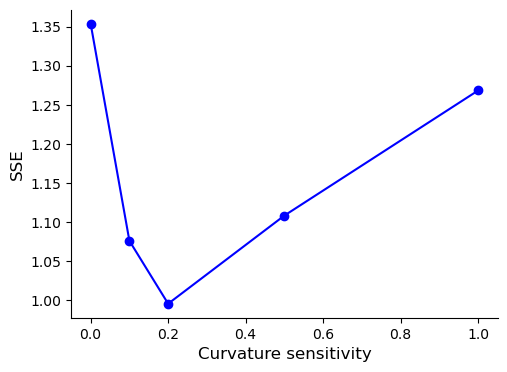

In [28]:
curvSens = [0, 1/10, 1/5, 1/2, 1]
errorsSel = [np.sum(errors[:,2]), np.sum(errors[:,1]), np.sum(errors[:,0]),
             np.sum(errors[:,5]), np.sum(errors[:,6])]
plt.plot(curvSens, errorsSel, 'bo-')
plt.ylabel("SSE")
plt.xlabel("Curvature sensitivity")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

conditions = []
# conditions.append("Flat 10 GPa")
for i in [0, 1, 2, 6, 7]:
    conditions.append(f"h{heightArray[i]}p{pitchArray[i]}r{radiusArray[i]}")
# conditions.append("Flat 14 kPa")
# conditions.append("Flat 7 kPa")
# conditions.append("Flat 3 kPa")
# conditions.append("Flat 1 kPa")
YAPTAZ_expt = np.array(yapData)
np_means = {
    'Experiments': YAPTAZ_expt[[0,1,2,6,7]],
    'No curv sens': YAPTAZ_ratios[[0,1,2,6,7],2],
    'Low curv sens': YAPTAZ_ratios[[0,1,2,6,7],1],
    'Mod. curv sens': YAPTAZ_ratios[[0,1,2,6,7],0],
    'High curv sens': YAPTAZ_ratios[[0,1,2,6,7],5],
}

x = np.arange(len(conditions))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in np_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('YAP/TAZ N/C')
ax.set_xticks(x + width, conditions)
ax.legend()#loc='upper right')
plt.ylim([0.0, 3.5])
# plt.savefig("/root/shared/gitrepos/pyplots/nanopillars/bargraph.pdf", format="pdf")

In [ ]:
contact_rad = 13
stiffness_vec = [0.1, 5.7, 70000000.0]
shape_vec = ["circle", "rect", "star"]
symm_vec = [0, 0.25, 0.5]
cyto_vol = 480
pm_area = 320
nuc_vol = 70.6
nm_area = 58.5
Ac = 133
# geoParam = [cyto_vol, nuc_vol, pm_area, nm_area, Ac]
geoParam = [[1925.03/4, nuc_vol, 1294.5/4, nm_area, Ac], [480.1, nuc_vol, 332.7, nm_area, Ac], [952.9/2, nuc_vol, 681.1/2, nm_area, Ac]]
var_names_all = ["Cofilin_P", "Fak", "mDia", "LaminA", "FActin", "RhoA_GTP", "mDia_A", "NPC_A", "GActin", "NPC",
        "ROCK_A", "Myo", "Cofilin_NP", "LaminA_p", "YAPTAZ_nuc", "pFak", "YAPTAZ_phos", "YAPTAZ", "RhoA_GDP", "LIMK",
        "Myo_A", "ROCK", "Positionboolean", "LIMK_A", "MRTF", "MRTF_nuc"]
# var_names_saved = ["Cofilin_NP", "Emod", "FActin", "GActin", "LaminA", "LIMK_A", "mDia_A", "MRTF", "MRTF_bound", "MRTF_nuc", 
#                    "Myo_A", "NPC_A", "pFAK", "RhoA_GDP", "RhoA_GTP", "ROCK_A", "YAPTAZ", "YAPTAZ_nuc", "YAPTAZ_phos"]
var_names_saved = ["Cofilin_NP", "Emod", "FActin", "GActin", "LaminA", "LIMK_A", "mDia_A", 
                   "Myo_A", "NPC_A", "pFAK", "RhoA_GDP", "RhoA_GTP", "ROCK_A", "YAPTAZ", "YAPTAZ_nuc", "YAPTAZ_phos"]
plot_name = "FActin"
ode_idx = var_names_all.index(plot_name)
results_idx = var_names_saved.index(plot_name) + 1 # add one because time is first el
fig, ax = plt.subplots()
for stiffness in stiffness_vec:
    for i in range(len(shape_vec)):
        file_cur = f"{cur_dir}/npy-files/{shape_vec[i]}_E{stiffness}_full3dfalse_results.npy"#results_{shape_vec[i]}_R{contact_rad}smooth_{stiffness}kPa_wellmixed=True_results.npy"
        results_cur = np.load(file_cur)
        plt.plot(results_cur[0], results_cur[results_idx],label=f"{shape_vec[i]} {stiffness} kPa")
        # plot ode solution
        # t_ode, ode_results = mechanotransduction_ode_calc([0, 10000], stiffness, geoParam[i])
        # plt.plot(t_ode, ode_results[:,ode_idx], linestyle='dashed', label=f"ODE {shape_vec[i]} {stiffness} kPa")

plt.legend()
plt.ylabel("F-actin (μM)")
plt.xlabel('Time (s)')
# plt.savefig("/root/shared/gitrepos/pyplots/Factin_notmixed.pdf", format="pdf")

In [ ]:
stiffness_vec = [7e7]#[0.1, 5.7, 70000000.0]
shape_vec = ["circle", "rect", "star"]
symm_vec = [0, 0.25, 0.5]
# plot YAP/TAZ N/C ratio
plot_names = ["YAPTAZ_phos", "YAPTAZ", "YAPTAZ_nuc"]
ode_idx = []
results_idx = []
for name in plot_names:
    results_idx.append(var_names_saved.index(name) + 1) # add one because time is first el
    ode_idx.append(var_names_all.index(name))
fig, ax = plt.subplots()
for stiffness in stiffness_vec:
    for i in range(len(shape_vec)):
        file_cur = f"{cur_dir}/npy-files/{shape_vec[i]}_E{stiffness}_full3dfalse_results.npy"#/results_{shape_vec[i]}_R{contact_rad}smooth_{stiffness}kPa_wellmixed=False_results.npy"
        results_cur = np.load(file_cur)
        yaptaz_curratio = results_cur[results_idx[2]]/(results_cur[results_idx[0]]+results_cur[results_idx[1]])
        plt.plot(results_cur[0], yaptaz_curratio, label=f"{shape_vec[i]} on glass")#{stiffness} kPa")
        file_old = f"{cur_dir}/results-redo/results_{shape_vec[i]}_R{contact_rad}smooth_{stiffness}kPa_wellmixed=False_results.npy"
        results_old = np.load(file_old)
        yaptaz_oldratio = results_old[results_idx[2]]/(results_old[results_idx[0]]+results_old[results_idx[1]])
        plt.plot(results_old[0], yaptaz_oldratio, label=f"{shape_vec[i]} on glass - orig", linestyle="dashed")#{stiffness} kPa")
        # plot ode solution
        # t_ode, ode_results = mechanotransduction_ode_calc([0, 10000], stiffness, geoParam[i])
        # ode_yaptazratio = ode_results[:,ode_idx[2]]/(ode_results[:,ode_idx[0]]+ode_results[:,ode_idx[1]])
        # plt.plot(t_ode, ode_yaptazratio, linestyle='dashed', label=f"ODE on glass {shape_vec[i]}")#{stiffness} kPa")

plt.legend()
plt.ylabel("YAP/TAZ N/C")
plt.xlabel('Time (s)')
# plt.savefig("/root/shared/gitrepos/pyplots/yaptaz_notmixed.pdf", format="pdf")